# IP CAM PROJECT

**Objective:** Be able to catch and display the video from multiple ip cameras.

---

**INPUT:** One or many urls where each is assigned to one ip camera.<br>
**OUTPUT:** Display of all provided cameras

---


**NOTES**<br>
I think the *ultimate goal of the project is to be able to source the ip cameras video just by using its ip adress and port* as well as login credentials. After I've done little of reaserch it turns out that there is many possible ways to get the extension of simple url `http://<username>:<password>@<ip>:<port>/` which is crucial to get the camera video. There are few ways of resolving problem:
- Make use of automate redirection of the request and scrap the desired links right from the webpage. In most cases after typing basic request such as `http://213.193.89.202:80/` into Google Chrome, redirection occur and HTML response of `http://213.193.89.202/mjpg/video.mjpg` shows up instead. The video we are looking for is part of the page mostly in format of images runnning through the network refreshing inplace.
- Use the online database of endpoints url links for huge variety of cameras `https://www.ispyconnect.com/sources.aspx`. First we would have to get the exact type and producent of camera and then scrap the database website.

---

**For sake of simplicity I assume that the link is already satysfying and create an architecture that converts them into grid of videos.**

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import requests
import time

### Helper functions

In [3]:
def print_break():
    print(40*'_')

def breaks_sandwich(func): 
    def inner(*args, **kwargs): 
        print_break()
        func(*args, **kwargs) 
        print_break()
    return inner

@breaks_sandwich
def print_paragraph(text='paragraph'):
    print(text)

    
print_paragraph('abcdefg')

________________________________________
abcdefg
________________________________________


In [4]:
def image_grid(images, subplot_dim=(3, 3), labels=None, figsize=(15, 10)):
    n_images = subplot_dim[0] * subplot_dim[1]
    assert len(images) >= n_images, f'Provided {len(images)} images is not enough for {subplot_dim} plot.'
    
    if labels:
        assert len(labels) == n_images
    else:
        labels = [f'img {i}' for i in range(len(images))]
        
    plt.figure(None, figsize, facecolor='black')
    for idx in range(n_images):
        plt.subplot(subplot_dim[0], subplot_dim[1], idx+1)
#         plt.subplots_adjust(hspace = 0.1)
        plt.imshow(images[idx])
        plt.title(labels[idx], fontdict={'color':'white'})
        plt.xticks([])
        plt.yticks([])
    plt.plot()

In [5]:
def plot_single_frame(img):
    plt.figure(figsize=(10, 5))
    plt.axis('off')
    plt.imshow(img)
    plt.title('SINGLE FRAME')
    plt.plot()

### URLs:

In [6]:
urls_mjpg = [
    'http://213.193.89.202/mjpg/video.mjpg',
    'http://174.6.126.86/mjpg/video.mjpg',
    'http://187.157.229.132/mjpg/video.mjpg',   
]

urls_jpg = [
    'http://91.133.85.170:8090/record/current.jpg',
]

### Handling .jpg content

In [7]:
def get_frame_jpg(url):
    img_data = requests.get(url).content
    arr = np.frombuffer(img_data, np.uint8)
    return cv2.imdecode(arr, cv2.IMREAD_COLOR)

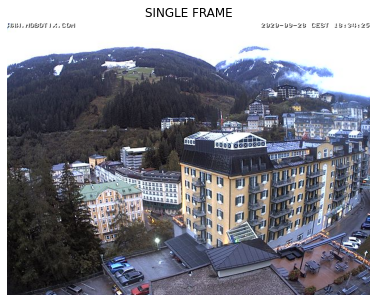

In [8]:
url = 'http://91.133.85.170:8090/record/current.jpg'
img = get_frame_jpg(url)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plot_single_frame(img)

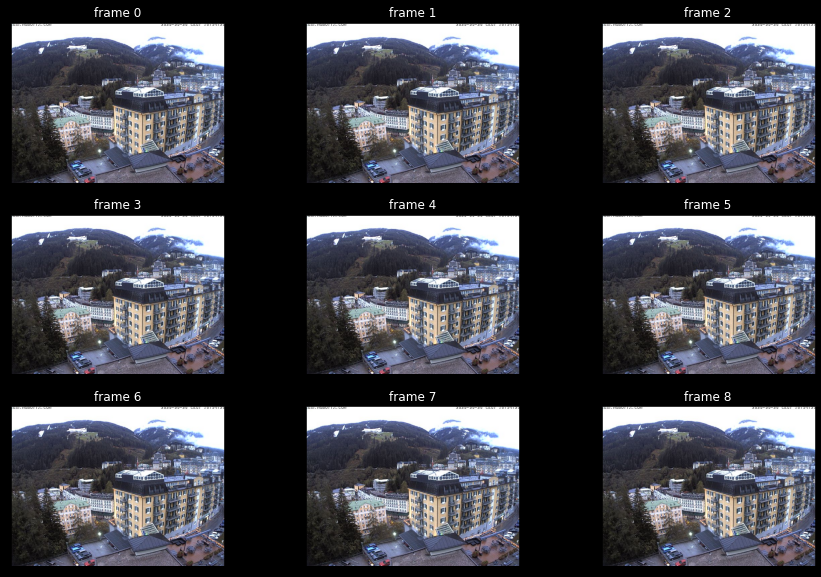

In [9]:
url = 'http://91.133.85.170:8090/record/current.jpg'
n = 9
images = [get_frame_jpg(url) for i in range(n)]
images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in images]

labels = [f'frame {i}' for i in range(len(images))]
image_grid(images, labels=labels)

### Handling .mjpg content (video)

In [10]:
def get_frame_mjpg(url):
    capture = cv2.VideoCapture(url)
    retval, image = capture.read()
    capture.release()
    
    return image

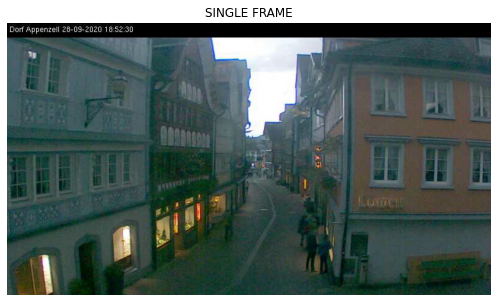

In [11]:
url = 'http://213.193.89.202/mjpg/video.mjpg'
img = get_frame_mjpg(url)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plot_single_frame(img)

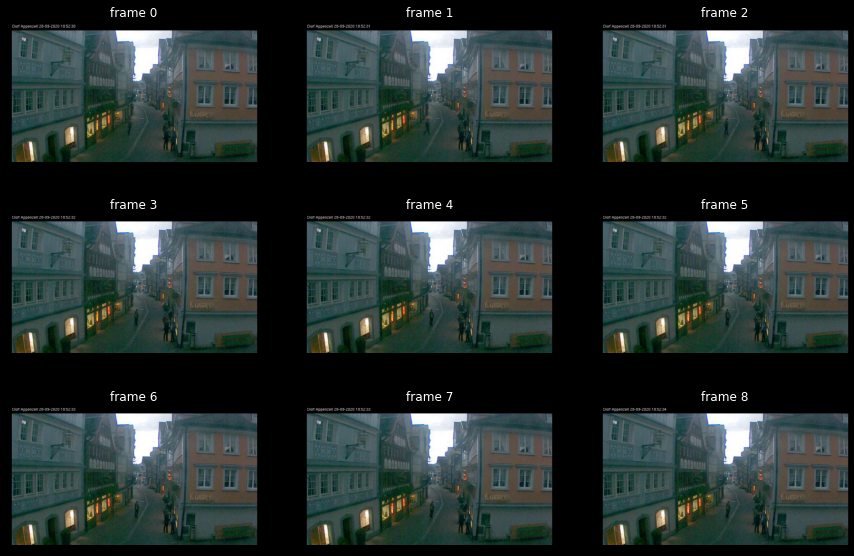

In [12]:
url = 'http://213.193.89.202/mjpg/video.mjpg'
n = 9
images = [get_frame_mjpg(url) for i in range(n)]
images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in images]

labels = [f'frame {i}' for i in range(len(images))]
image_grid(images, labels=labels)

In [13]:
# HANDLES MULTIPLE FRAMES

# def get_mjpg(url, n=1):
#     capture = cv2.VideoCapture(url)
#     counter = 0
#     images = []
#     while counter < n:
#         retval, img = capture.read()
#         images.append(img)
#         counter += 1
#     capture.release()
    
#     return images

# #####
# url = 'http://213.193.89.202/mjpg/video.mjpg'
# imgs = get_mjpg(url, 3)
# imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in imgs]
# img = imgs[0]

# plot_single_frame(img)
# #####
# url = 'http://213.193.89.202/mjpg/video.mjpg'
# images = get_mjpg(url, 9)
# images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in images]
# labels = [f'frame{i}' for i in range(len(images))]
# image_grid(images, labels=labels)

### ipCam

In [23]:
class ipCam(object):
    
    
    def __init__(self, url):
        self.url = url
        
        available_formats = ['.jpg', '.mjpg']
        self.format_ = ''.join([format_ if format_ in url.lower() else '' for format_ in available_formats])
        print(f'Format ERROR!\nExpected to be one of {available_formats}.') if self.format_ == '' else print(f'Detected format: {self.format_}.')
        
    
    def get_single_frame(self):
        if self.format_ == '.jpg':
            frame = self.__get_frame_jpg__()
        elif self.format_ == '.mjpg':
            frame = self.__get_frame_mjpg__()
        else:
            frame = None
            print(f'Format ERROR!\nExpected to be one of {available_formats}.')
        return frame
    
    def __get_frame_mjpg__(self):
        capture = cv2.VideoCapture(self.url)
        retval, image = capture.read()
        capture.release()
        return image
    
    def __get_frame_jpg__(self):
        img_data = requests.get(self.url).content
        arr = np.frombuffer(img_data, np.uint8)
        return cv2.imdecode(arr, cv2.IMREAD_COLOR)

Detected format: .jpg.
URL: http://91.133.85.170:8090/record/current.jpg

----------

Detected format: .mjpg.
URL: http://213.193.89.202/mjpg/video.mjpg

----------



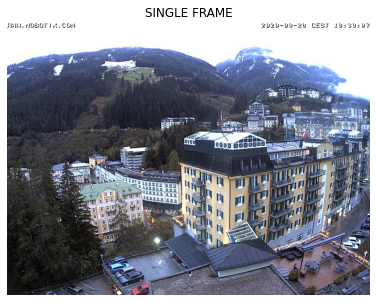

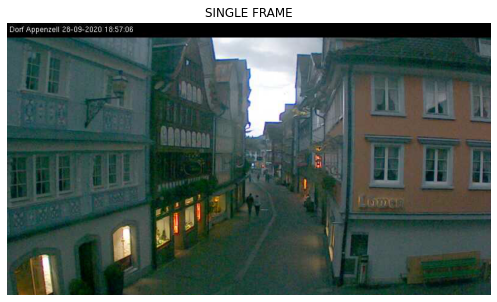

In [24]:
def test(url):
    cam = ipCam(url)
    print(f'URL: {cam.url}')
    frame = cam.get_single_frame()
    
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plot_single_frame(frame)

test_urls = ['http://91.133.85.170:8090/record/current.jpg',
             'http://213.193.89.202/mjpg/video.mjpg',
            ]

for test_url in test_urls:
    test(test_url)
    print('\n----------\n')

---

### Note

Below code shows that automatic redirect not always work because of `requestes` library limits wchih cannot turn JavaScript on

>[...]`<noscript>Your browser has JavaScript turned off.<br>For the user interface to work, you must enable JavaScript in your browser and reload/refresh this page.\n  </noscript>`[...]

In [16]:
requests.get('http://213.193.89.202:80').content

b'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN">\n<HTML>\n<HEAD>\n  <meta http-equiv="X-UA-Compatible" content="IE=7" />\n  <meta http-equiv="Expires" content="Tue, 12 May 1962 1:00:00 GMT">\n  <meta http-equiv="Pragma" content="no-cache">\n  <meta http-equiv="Cache-Control" content="no-cache">\n  <meta http-equiv="Content-type" CONTENT="text/html; charset=iso-8859-1">\n  <meta http-equiv="Content-language" CONTENT="en">\n\n  <META HTTP-EQUIV="Refresh" CONTENT="0; URL=/view/viewer_index.shtml?id=211760">\n  <title>Index page</title>\n  <noscript>Your browser has JavaScript turned off.<br>For the user interface to work, you must enable JavaScript in your browser and reload/refresh this page.\n  </noscript>\n</HEAD>\n<BODY>\n</BODY>\n</HTML>\n'

When `http://213.193.89.202:80` link is called inside Google Chrome, redirect drives to page `http://213.193.89.202/view/viewer_index.shtml?id=208905` which one of part is video data we're looking for.

**This behaviour may be simulate with `selenium` library.**

---

---

### Example:

**IP: 213.193.89.202**<br>
**PORT: 80** (default)

URL simple structure: `http://<IP>:<PORT>/`<br>
URL full: `http://<username>:<password>@<IP>:<PORT>/`


1. Adress build of IP and PORT. `http://213.193.89.202:80/`

2. Automatilcally redirect to the full webpage. `http://213.193.89.202/view/viewer_index.shtml?id=205418`

3. Link straight to the video is part of the content of previous page. `http://213.193.89.202/mjpg/video.mjpg`

---

In [17]:
urls = ['http://91.133.85.170:8090/', #MOBOTIX
        'http://213.193.89.202:80/', #Axis
        'http://211.248.20.173:8080/', #WEBCAMXP
        'http://77.243.103.105:8081/', #Axis
        'http://220.254.136.170/', #BB-SW
       ]

# Camera url extensions database

One idea is to find and use cameras exact model to find relevant full url pointing to the video source. Extensions for different cameras might be found here: `https://www.ispyconnect.com/sources.aspx?n=<camera model>`.

# Uwagi
- Filmiki są przesyłane jako seria obrazków jeden po drugim, co dobrze widać gdy analizuje się **Network Traffic** w inspektorze Google Chrome. Każdy obraz jest oznaczony kategorią **IMG** co powinno ułatwić pobieranie danych.

In [18]:
ip = '213.193.89.202'
port = '80'

url = f'http://{ip}:{port}/'

response = requests.get(url, params={}, allow_redirects=True, timeout=5, verify=False)
assert response.status_code == 200, f'** {response.status_code}: ERROR status code. **'

# print_paragraph(f'RESPONSE URL:\n\n{response.url}')
print_paragraph(f'HEADER:\n\n{response.headers}')
print_paragraph(f'CONTENT:\n\n{response.content}')
print_paragraph(f'HISTORY:\n\n{response.history}')

________________________________________
HEADER:

{'Content-Length': '748', 'Last-Modified': 'Mon, 28 Sep 2020 16:52:38 GMT', 'Cache-Control': 'no-cache', 'Content-Type': 'text/html'}
________________________________________
________________________________________
CONTENT:

b'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN">\n<HTML>\n<HEAD>\n  <meta http-equiv="X-UA-Compatible" content="IE=7" />\n  <meta http-equiv="Expires" content="Tue, 12 May 1962 1:00:00 GMT">\n  <meta http-equiv="Pragma" content="no-cache">\n  <meta http-equiv="Cache-Control" content="no-cache">\n  <meta http-equiv="Content-type" CONTENT="text/html; charset=iso-8859-1">\n  <meta http-equiv="Content-language" CONTENT="en">\n\n  <META HTTP-EQUIV="Refresh" CONTENT="0; URL=/view/viewer_index.shtml?id=211761">\n  <title>Index page</title>\n  <noscript>Your browser has JavaScript turned off.<br>For the user interface to work, you must enable JavaScript in your browser and reload/refresh this page.\n  </no

---
Made by **[Patryk Laskowski](https://github.com/patryklaskowski)**